In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# **Positional Embedding**



<center>
  <img src="https://drive.google.com/uc?id=12ynIMGE3uF3fHkoSXL9qKFjbebE0GCqo" width="300" height="200">
</center>



<center>
  <img src="https://drive.google.com/uc?id=1hWotFrT2A4wCDEiw239CeIqeENs0IGA_" width="300" height="100">
</center>



In [ ]:
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding

    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size

    Returns:
        angles -- (pos, d) numpy array
    """
    angles = pos/ (np.power(10000, (2 * (i//2)) / np.float32(d)))

    return angles

In [ ]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int) -- Maximum number of positions to be encoded
        d (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[ np.newaxis,:],
                            d)

    # -> angle_rads has dim (positions,d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])


    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


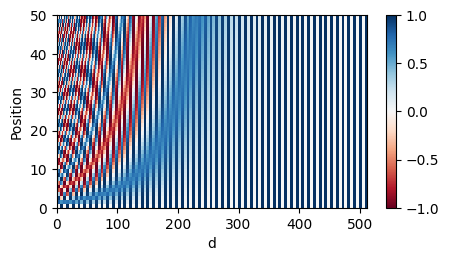

In [ ]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)
plt.figure(figsize=(5, 2.5))  # Set the figure size
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, vocab_size: int, d_model: int, embedding: tf.keras.layers.Embedding=None):
        """ Constructor of the PositionalEmbedding layer.

        Args:
            vocab_size (int): The size of the vocabulary. I. e. the number of unique tokens in the input sequence.
            d_model (int): The dimensionality of the embedding vector.
            embedding (tf.keras.layers.Embedding): The custom embedding layer.
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(positions=2048, d=d_model)


    def call(self, x: tf.Tensor) -> tf.Tensor:
        """ Performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input tensor of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of embedding vectors with added positional information. The shape is
                (batch_size, seq_length, d_model).
        """

        x = self.embedding(x)
        seq_length = tf.shape(x)[1]
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        pos_encoding = self.pos_encoding[:, :seq_length, :]
        x = x + pos_encoding
        return x


# **Attentions**



<center>
  <img src="https://drive.google.com/uc?id=1pIfFYdjTO-XCs1WHUkUrn3iHUuavKd4c" width="300" height="300">
</center>


In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """
       Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e. g.
                        num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## 1. DecoderEncoderAttention




<center>
  <img src="https://drive.google.com/uc?id=1nfAv7-VV8Q6FzEtLX_mG0M3J3_oKGqLl" width="300" height="300">
</center>




<center>
  <img src="https://drive.google.com/uc?id=1rhK2GFHzQFTc2mYTMtkljGxFXSHgGY8x" width="200" height="200">
</center>


In [ ]:
class DecoderEncoderAttention(BaseAttention):
    """
    A class that implements the attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        Args:
            x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
            context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

## 2. EncoderAttention


<center>
  <img src="https://drive.google.com/uc?id=16L7nqpHOpDJYZTztsebmLOKzVCba_Tl_" width="300" height="300">
</center>



<center>
  <img src="https://drive.google.com/uc?id=1y0bKchVMAjugUXfzZym8dhdEyhwVlRUB" width="200" height="200">
</center>



In [ ]:
class EncoderAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

## 3. DecoderAttention



<center>
  <img src="https://drive.google.com/uc?id=1FjA8wBOuwNxo-k0rtzBqu6QV3QetxU2Q" width="300" height="300">
</center>






<center>
  <img src="https://drive.google.com/uc?id=1lkjcApYxnaQPKTVRRdEqWYc2wz7myELn" width="200" height="200">
</center>

In [ ]:
class DecoderAttention(BaseAttention):
    """
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

# **Feed Forward Network**





<center>
  <img src="https://drive.google.com/uc?id=135uzG1UOm8b2c7t4YV1Y1b76O0pTkXNy" width="300" height="300">
</center>


In [ ]:
class FeedForward(tf.keras.layers.Layer):
    """
    A class that implements the feed-forward layer.

    Attributes:
        seq (tf.keras.Sequential): The sequential layer that contains the feed-forward layers. It applies the two feed-forward layers and the dropout layer.
        add (tf.keras.layers.Add): The Add layer.
        layer_norm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
    """
    def __init__(self, d_model: int, dff: int, dropout_rate: float=0.1):
        """
        Args:
            d_model (int): The dimensionality of the model.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# **Encoder**





<center>
  <img src="https://drive.google.com/uc?id=1gGcKZQXDMs9TrG5FID6l0RT76PDiKuTG" width="350" height="400">
</center>


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Encoder. Usually there are multiple layers stacked on top of each other.

    Attributes:
        self_attention (EncoderAttention): The Encoder self-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the EncoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.self_attention = EncoderAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
            )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Encoder.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the encoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        enc_layers (list): The list of encoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Encoder.

        Args:
            num_layers (int): The number of layers in the encoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.pos_embedding(x)
        # here x has shape `(batch_size, seq_len, d_model)`

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

# **Decoder**




<center>
  <img src="https://drive.google.com/uc?id=18ZfCKJCXg2SV6EPz3_VGpF4zc1UZk6cw" width="350" height="400">
</center>



In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Decoder. Usually there are multiple layers stacked on top of each other.

    Attributes:
        Decoder _attention (DecoderAttention): The Decoder  self-attention layer.
        Decoder-encoder_attention (DecoderEncoderAttention): The Decoder-encoder-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the DecoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super(DecoderLayer, self).__init__()

        self.Decoder_self_attention = DecoderAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.DecoderEncoder_attention = DecoderEncoderAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model). x is usually the output of the previous decoder layer.
            context (tf.Tensor): The context sequence of shape (batch_size, seq_length, d_model). Context is usually the output of the encoder.
        """
        x = self.Decoder_self_attention(x=x)
        x = self.DecoderEncoder_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.DecoderEncoder_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x




<center>
  <img src="https://drive.google.com/uc?id=1Z0h5BerG5BqmVNx_E2UTyJCQn611Vie1" width="350" height="400">
</center>

In [ ]:
class Decoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Decoder.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the decoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        dec_layers (list): The list of decoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Decoder.

        Args:
            num_layers (int): The number of layers in the decoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model,
                num_heads=num_heads,
                dff=dff,
                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, target_seq_len).
            context (tf.Tensor): The context sequence of shape (batch_size, input_seq_len, d_model).
        """
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

# **Transformer**


<center>
  <img src="https://drive.google.com/uc?id=130A4xb3WlnN117Z12hbYxmLr8TJDB_NI" width="300" height="500">
</center>

In [ ]:
def Transformer(
    input_vocab_size: int,
    target_vocab_size: int,
    encoder_input_size: int = None,
    decoder_input_size: int = None,
    num_layers: int=6,
    d_model: int=512,
    num_heads: int=8,
    dff: int=2048,
    dropout_rate: float=0.1,
    ) -> tf.keras.Model:
    """
    A custom TensorFlow model that implements the Transformer architecture.

    Args:
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        encoder_input_size (int): The size of the encoder input sequence.
        decoder_input_size (int): The size of the decoder input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of heads in the multi-head attention layer.
        dff (int): The dimensionality of the feed-forward layer.
        dropout_rate (float): The dropout rate.

    Returns:
        A TensorFlow Keras model.
    """
    inputs = [
        tf.keras.layers.Input(shape=(encoder_input_size,), dtype=tf.int64),
        tf.keras.layers.Input(shape=(decoder_input_size,), dtype=tf.int64)
        ]

    encoder_input, decoder_input = inputs

    encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(encoder_input)
    decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)(decoder_input, encoder)

    output = tf.keras.layers.Dense(target_vocab_size)(decoder)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
encoder_input_size = 100
decoder_input_size = 110

encoder_vocab_size = 1000
decoder_vocab_size = 1000

model = Transformer(
    input_vocab_size=encoder_vocab_size,
    target_vocab_size=decoder_vocab_size,
    encoder_input_size=encoder_input_size,
    decoder_input_size=decoder_input_size,
    num_layers=2,
    d_model=512,
    num_heads=2,
    dff=512,
    dropout_rate=0.1)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 110)]                0         []                            
                                                                                                  
 encoder (Encoder)           (None, 100, 512)             5768192   ['input_1[0][0]']             
                                                                                                  
 decoder (Decoder)           (None, 110, 512)             9971712   ['input_2[0][0]',             
                                                                     'encoder[0][0]']         